In [2]:
""" import cvxpy as cp
import numpy as np

# Create two scalar optimization variables.
x = cp.Variable(2)
n = np.array([[1, -1]])
# Create two constraints.
constraints = [cp.cp.norm(x) <= 1]

# Form objective.
obj = cp.Minimize(n @ x)

# Form and solve problem.
prob = cp.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value) """

' import cvxpy as cp\nimport numpy as np\n\n# Create two scalar optimization variables.\nx = cp.Variable(2)\nn = np.array([[1, -1]])\n# Create two constraints.\nconstraints = [cp.cp.norm(x) <= 1]\n\n# Form objective.\nobj = cp.Minimize(n @ x)\n\n# Form and solve problem.\nprob = cp.Problem(obj, constraints)\nprob.solve()  # Returns the optimal value.\nprint("status:", prob.status)\nprint("optimal value", prob.value)\nprint("optimal var", x.value) '

In [2]:
import cvxpy as cp
import numpy as np

# Adapted from https://github.com/jonnyhyman/G-FOLD-Python/blob/master/Static_Solution/GFOLD_Static.py

In [3]:
#x, y, z
r0 = np.array([10, 4, 10])                   # initial position
r_dot0 = np.array([2, 0, -1])                    # initial velocity

rf = np.array([0, 0, 0])                      # final position target
r_dotf = np.array([0, 0, 0])                      # final velocity target

g = np.array([0, 0, -9.80655])              # gravity

y_gs  = np.radians(10) # glide slope cone, must be 0 < Degrees < 90
tany_gs = np.tan(y_gs)

In [13]:
mass = 1
Thrust = 20

In [14]:
def solve(inputs):

    if inputs[0]==3:
        program, N, dt = inputs
    elif inputs[0]==4:
        program, N, dt, optimal_value = inputs


    x0 = cp.Parameter()
    x0 = np.array(np.concatenate([r0, r_dot0]))

    x = cp.Variable((6, N)) # state vector (3position,3velocity)
    u = cp.Variable((3, N))

    constraints = []

    constraints += [ x[:, 0]  == x0 ] 
    constraints += [ x[3:6, N-1] == r_dotf ] # don't forget to slow down, buddy!

    constraints += [ x[2, N-1] == 0 ] # lands on ground

    if program == 4:
        constraints += [ cp.norm(x[0:2, N-1] - rf[:2]) <= optimal_value ]

    for n in range(0,N-1): # any t in [0,tf] maps to any n in [0,N-1]
        # In this synchronized form, the time-step dt must be constant to maintain stability
        constraints += [ x[3:6, n+1] == x[3:6,n] + dt * ((u[:,n] + u[:,n + 1]) / 2  + g) ] # r_dot(t + dt) = r_dot(t) + dt * (g + (T_c(t) + T_c(t + dt))/(2*m) )
        constraints += [ x[0:3,n+1] == x[0:3,n] + (dt/2) * (x[3:6,n+1] + x[3:6,n]) + dt**2/12 * (u[:,n+1] - u[:,n]) ]

    for n in range(0, N):
        constraints += [ cp.norm( (x[0:3, n] - rf)[0:2] ) - (x[2,n] - rf[2]) / tany_gs <= 0 ] # specific, but faster

        constraints += [cp.norm(u[:,n]) <= Thrust / mass] # limit thrust magnitude

    constraints += [x[2, :] >= 0] # no, this is not the Boring Company! Strict inequalities are not allowed so can't do x[2, 1:] > 0


    if program == 3:
        print('-----------------------------')
        objective = cp.Minimize(cp.norm(x[0:2, N-1] - rf[:2])) # minimise landing error
        problem = cp.Problem(objective, constraints)
        obj_opt = problem.solve()#solver=ECOS, verbose=True, feastol=5e-20)#solver=SCS,max_iters=5000,verbose=True,use_indirect=False)
        print("status:", problem.status)
        print("cost:", problem.value)
        print('-----------------------------')
    elif program == 4:
        print('-----------------------------')
        objective = cp.Minimize(cp.norm(cp.norm(T_c, axis = 0))) # Hacky way to get ||T_c|| = Thrust
        problem = cp.Problem(objective, constraints)
        obj_opt = problem.solve()#solver=ECOS, verbose=True, feastol=5e-20)#solver=SCS,max_iters=5000,verbose=True,use_indirect=False)
        print("status:", problem.status)
        print("cost:", problem.value)
        print('-----------------------------')

    return obj_opt, x, u

In [17]:
dt = 0.05
N = int(3.45 / dt) + 1

obj_opt, x, u = solve((3, N, dt))
T_c = u * mass

-----------------------------
status: optimal
cost: 6.117295942886558e-13
-----------------------------
[[-6.33132534e+00 -6.98280165e+00 -8.51723862e+00 -9.74068493e+00
  -1.04648356e+01 -1.05463622e+01 -1.00834930e+01 -9.30920347e+00
  -8.43096788e+00 -7.57292127e+00 -6.79226119e+00 -6.10649904e+00
  -5.51292401e+00 -5.00009346e+00 -4.55391834e+00 -4.16059008e+00
  -3.80784397e+00 -3.48541606e+00 -3.18512973e+00 -2.90080663e+00
  -2.62807331e+00 -2.36408339e+00 -2.10716517e+00 -1.85641760e+00
  -1.61130255e+00 -1.37130048e+00 -1.13569349e+00 -9.03503080e-01
  -6.73555154e-01 -4.44604124e-01 -2.15446443e-01  1.50127445e-02
   2.47736352e-01  4.83550937e-01  7.23138597e-01  9.67016637e-01
   1.21550994e+00  1.46872853e+00  1.72656420e+00  1.98871673e+00
   2.25475094e+00  2.52416883e+00  2.79645541e+00  3.07103397e+00
   3.34707420e+00  3.62316845e+00  3.89701137e+00  4.16527948e+00
   4.42376504e+00  4.66739054e+00  4.88895224e+00  5.07446423e+00
   5.19462949e+00  5.20532916e+00  5.0

In [20]:
def solve(inputs):

    if inputs[0]==3:
        program, N, dt = inputs
    elif inputs[0]==4:
        program, N, dt, optimal_value = inputs

    mass = 1
    Thrust = 20 * np.ones(N)

    x0 = cp.Parameter()
    x0 = np.array(np.concatenate([r0, r_dot0]))

    x = cp.Variable((6, N)) # state vector (3position,3velocity)
    T_c = cp.Variable((3, N))
    Gamma = cp.Variable(N)
    fuel = cp.Variable(N)

    constraints = []

    constraints += [ x[:, 0]  == x0 ] 
    constraints += [ x[3:6, N-1] == r_dotf ] # don't forget to slow down, buddy!

    constraints += [ T_c[:, 0] == 10 * np.array([0, 0, 1]) ] # thrust direction starts straight, initial attitude?
    constraints += [ T_c[:, N-1] == 10 * np.array([0, 0, 1]) ] # and ends straight

    constraints += [ x[2, N-1] == 0 ] # lands on ground

    constraints += [ fuel[0] == 0 ] #integral starts at 0
    constraints += [ Gamma [N - 1] == 0 ] # Thrust at end is 0

    if program == 4:
        constraints += [ cp.norm(x[0:2, N-1] - rf[:2]) <= optimal_value ]

    for n in range(0, N-1): # any t in [0,tf] maps to any n in [0,N-1]

        # Leapfrog Integration Method
        #    accurate +/- sqrt( (dt*df/dr)**2 + 1)
        #    https://goo.gl/jssWkB
        #    https://en.wikipedia.org/wiki/Leapfrog_integration

        # Dynamics --> v = A(w)*x + B*(g + u)

        # In this synchronized form, the time-step dt must be constant to maintain stability
        constraints += [ x[3:6, n+1] == x[3:6,n] + dt * ((T_c[:,n] + T_c[:,n + 1]) / (2 * mass) + g) ] # r_dot(t + dt) = r_dot(t) + dt * (g + (T_c(t) + T_c(t + dt))/(2*m) )
        constraints += [ x[0:3, n+1] == x[0:3,n] + (dt/2) * (x[3:6,n+1] + x[3:6,n]) ]

        # v_half = x[3:6, n] + (T_c[:,n] / mass + g) * dt / 2
        # constraints += [ x[0:3,n+1] == x[0:3,n] + v_half * dt / 2 ]
        # constraints += [ x[3:6, n+1] == v_half + (T_c[:, n+1] / mass + g) * dt / 2 ]

        #constraints += [ cp.norm(E*(x[0:3,n]-rf)) - c.T*(x[0:3,n]-rf) <= 0 ] # glideslope, full generality # (5)
        constraints += [ cp.norm( (x[0:3, n] - rf)[0:2] ) - (x[2,n] - rf[2]) / tany_gs  <= 0 ] # specific, but faster

        #constraints += [ cp.norm(x[3:6,n]) <= V_max ] # velocity
        constraints += [cp.norm(T_c[:,n]) <= Gamma[n]] # limit thrust magnitude
        constraints += [Gamma[n] <= Thrust[n]] 
        constraints += [Gamma[n] >= Thrust[n] - 0.1] 

        constraints += [ fuel[n + 1] == fuel[n] + dt / 2 * (Gamma[n] + Gamma[n + 1]) ]

        # Thrust pointing constraints
        #constraints += [ nh.T*u[:,n] >= np.cos(p_cs)*G[n]  ] # full generality
        #constraints += [ T_c[0,n] >= np.cos(p_cs)*s[n]  ]

    constraints += [x[2, :] >= 0] # no, this is not the Boring Company! Strict inequalities are not allowed so can't do x[2, 1:] > 0


    if program == 3:
        print('-----------------------------')
        objective = cp.Minimize(cp.norm(x[0:2, N-1] - rf[:2])) # minimise landing error
        problem = cp.Problem(objective, constraints)
        obj_opt = problem.solve()#solver=ECOS, verbose=True, feastol=5e-20)#solver=SCS,max_iters=5000,verbose=True,use_indirect=False)
        print("status:", problem.status)
        print("cost:", problem.value)
        print('-----------------------------')
    elif program == 4:
        print('-----------------------------')
        objective = cp.Minimize(fuel[N - 1]) # Hacky way to get ||T_c|| = Thrust
        problem = cp.Problem(objective, constraints)
        obj_opt = problem.solve()#solver=ECOS, verbose=True, feastol=5e-20)#solver=SCS,max_iters=5000,verbose=True,use_indirect=False)
        print("status:", problem.status)
        print("cost:", problem.value)
        print('-----------------------------')

    return obj_opt, x, T_c, Gamma, fuel

In [21]:
invphi = (np.sqrt(5) - 1) / 2  # 1 / phi
invphi2 = (3 - np.sqrt(5)) / 2  # 1 / phi^2

def gss(f, a, b, tol=1e-5):
    """Golden-section search.

    Given a function f with a single local minimum in
    the interval [a,b], gss returns a subset interval
    [c,d] that contains the minimum with d-c <= tol.

    Example:
    >>> f = lambda x: (x-2)**2
    >>> a = 1
    >>> b = 5
    >>> tol = 1e-5
    >>> (c,d) = gss(f, a, b, tol)
    >>> print(c, d)
    1.9999959837979107 2.0000050911830893
    """

    (a, b) = (min(a, b), max(a, b))
    h = b - a
    if h <= tol:
        return (a, b)

    # Required steps to achieve tolerance
    n = int(np.ceil(np.log(tol / h) / np.log(invphi)))

    c = a + invphi2 * h
    d = a + invphi * h
    yc = f(c)
    yd = f(d)

    for k in range(n-1):
        if yc < yd:
            b = d
            d = c
            yd = yc
            h = invphi * h
            c = a + invphi2 * h
            yc = f(c)
        else:
            a = c
            c = d
            yc = yd
            h = invphi * h
            d = a + invphi * h
            yd = f(d)

    if yc < yd:
        return (a, d)
    else:
        return (c, b)

In [ ]:
dt = 0.05
N = int(3.45 / dt) + 1

def problem3_seach(t_f):
    obj_opt, x, T_c, Gamma, fuel = solve((3, int(t_f / dt) + 1, dt))
    return obj_opt

lower, upper = gss(problem3_seach, 0, 10, dt/2)

N = int((lower + upper) / 2 / dt) + 1
obj_opt, x, T_c, Gamma, fuel = solve((3, N, dt))
optimal_4, x, T_c, Gamma, fuel = solve((4, N, dt, obj_opt))

Text(0, 0.5, 'Magnitude (N)')

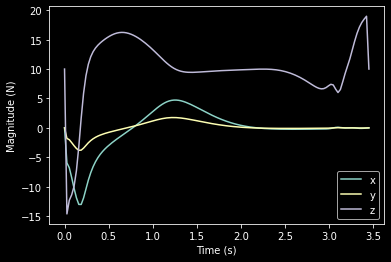

In [18]:
import matplotlib.pyplot as plt

T = np.linspace(0, 3.45, N)

plt.plot(T, np.transpose(T_c.value))

plt.legend(['x', 'y', 'z'])
plt.xlabel("Time (s)")
plt.ylabel("Magnitude (N)")

Text(0, 0.5, 'Thrust (N)')

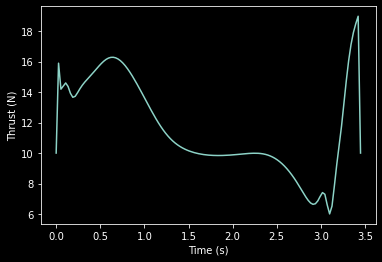

In [19]:
plt.plot(T, np.linalg.norm(T_c.value, axis = 0))
plt.xlabel("Time (s)")
plt.ylabel("Thrust (N)")

Text(0, 0.5, 'Height (m)')

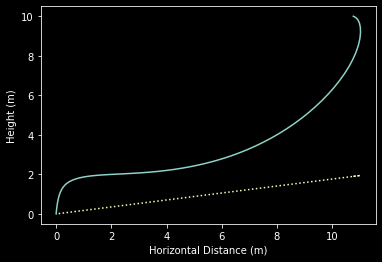

In [12]:
horizontal_distance = np.linalg.norm(np.transpose(x.value[:2, :]) - rf[:2], axis = 1)
plt.plot(horizontal_distance, x.value[2, :])
plt.plot(horizontal_distance, horizontal_distance * tany_gs, linestyle = 'dotted')
plt.xlabel("Horizontal Distance (m)")
plt.ylabel("Height (m)")

In [13]:
Gamma.value

array([1.99401638e+01, 1.99391257e+01, 1.99412175e+01, 1.99419529e+01,
       1.99420911e+01, 1.99419564e+01, 1.99417133e+01, 1.99414518e+01,
       1.99412216e+01, 1.99410440e+01, 1.99409229e+01, 1.99408530e+01,
       1.99408260e+01, 1.99408325e+01, 1.99408626e+01, 1.99409065e+01,
       1.99409550e+01, 1.99409999e+01, 1.99410351e+01, 1.99410565e+01,
       1.99410625e+01, 1.99410539e+01, 1.99410332e+01, 1.99410041e+01,
       1.99409713e+01, 1.99409396e+01, 1.99409134e+01, 1.99408968e+01,
       1.99408924e+01, 1.99409021e+01, 1.99409263e+01, 1.99409645e+01,
       1.99410146e+01, 1.99410738e+01, 1.99411384e+01, 1.99412044e+01,
       1.99412676e+01, 1.99413240e+01, 1.99413704e+01, 1.99414045e+01,
       1.99414254e+01, 1.99414332e+01, 1.99414296e+01, 1.99414172e+01,
       1.99414000e+01, 1.99413822e+01, 1.99413687e+01, 1.99413642e+01,
       1.99413728e+01, 1.99413975e+01, 1.99414396e+01, 1.99414983e+01,
       1.99415694e+01, 1.99416457e+01, 1.99417152e+01, 1.99417586e+01,
      